# Adult Income — Modeling

**Dataset:** Becker, B. & Kohavi, R. (1996). *Adult* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20 

**Target:** predict whether annual income exceeds **$50K/yr** from census features.

**Goal of this notebook**

Load the **processed data** (`adult.parquet`), perform the **train/test split here**, build **sklearn Pipelines** (impute+encode+model), compare models via **Stratified CV**, and evaluate on holdout with plots and conclusions.

## IMPORTS AND DATA LOADING

In [3]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')


# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


# package versions
import sklearn
print('python', sys.version.split()[0])
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('scikit-learn', sklearn.__version__)
print('matplotlib', plt.matplotlib.__version__)
print('seaborn', sns.__version__)


# plot defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

python 3.10.18
pandas 2.3.2
numpy 2.2.6
scikit-learn 1.7.2
matplotlib 3.10.6
seaborn 0.13.2


In [2]:
import mlflow
import mlflow.sklearn

# MLflow setup to log into local directory
mlflow.set_tracking_uri("file:///c:/Users/Maria/Desktop/CAPGEMINI/MDI-TestDataScience-1/mlruns")
mlflow.set_experiment("adult_income_models")  

<Experiment: artifact_location='file:///c:/Users/Maria/Desktop/CAPGEMINI/MDI-TestDataScience-1/mlruns/357016815056908421', creation_time=1758732139614, experiment_id='357016815056908421', last_update_time=1758732139614, lifecycle_stage='active', name='adult_income_models', tags={'mlflow.experimentKind': 'custom_model_development'}>

## MODELING DATA
Modeling data involves structuring and preparing data for modeling techniques, and applying algorithms to make predictions or discover patterns. In our case, we will use Scikit-learn library to split data into train and test.

In [5]:
# load data
DATA_PATH = Path("../data/processed/adult.parquet")
df = pd.read_parquet(DATA_PATH)
print('Shape:', df.shape)

Shape: (30718, 14)


In [6]:
df.head(5)

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Prev-Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married,Handlers-cleaners,Husband,Other,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married,Prof-specialty,Wife,Other,Female,0,0,40,Other,0


## SPLITTING DATA

Splitting data into **training** and **testing** sets is essential in ML to create a robust, generalized model by providing an unbiased evaluation of its performance on unseen data. The **training** set allows the model to learn patterns and optimize its parameters, while the **testing** set ensures the model can apply its learned knowledge to new situations without being biased by the training data, thereby preventing overfitting and providing a true measure of its real-world effectiveness

In [9]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets with stratification (80% train, 20% test)
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (24574, 13)
Test shape: (6144, 13)


In [11]:
y_train.mean(), y_test.mean()

(np.float64(0.24904370472857493), np.float64(0.2490234375))

## BASELINE MODELS

- **Dummy (most_frequent):** always predicts the majority class — strong anchor under imbalance.
- **Dummy (stratified):** samples according to class prior — reflects “no-signal” behavior.

Any candidate must **beat** these on **balanced** metrics (macro-F1, ROC-AUC).

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [12]:
# We identify categorical and numerical columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if c not in cat_cols]

In [ ]:
# We create preprocessing pipelines for both numeric and categorical data.
# Numerical features: median imputation + standard scaling
# Categorical features: most frequent imputation + one-hot encoding
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown='ignore'))
])

In [27]:
# We combine both transformers into a single ColumnTransformer
preprocessor = ColumnTransformer([('cat', cat_transformer, cat_cols),
                                 ('num', num_transformer, num_cols)])

In [28]:
# Baseline models setup
dummy_mostfreq_clf = Pipeline([('preprocessor', preprocessor), ('clf', DummyClassifier(strategy='most_frequent'))])
dummy_strat_clf = Pipeline([('preprocessor', preprocessor), ('clf', DummyClassifier(strategy='stratified'))])

## LOGISTIC REGRESSION
**Logistic regression** is a classification algorithm, used when the value of the target variable is categorical in nature. Whereas Linear regression assumes that the data follows a linear function, Logistic models the data using the sigmoid function, which ensures that the model output always falls between 0 and 1. The sigmoid function is defined as follows:

$$ y = \frac{1}{1+ e^{-z}} $$



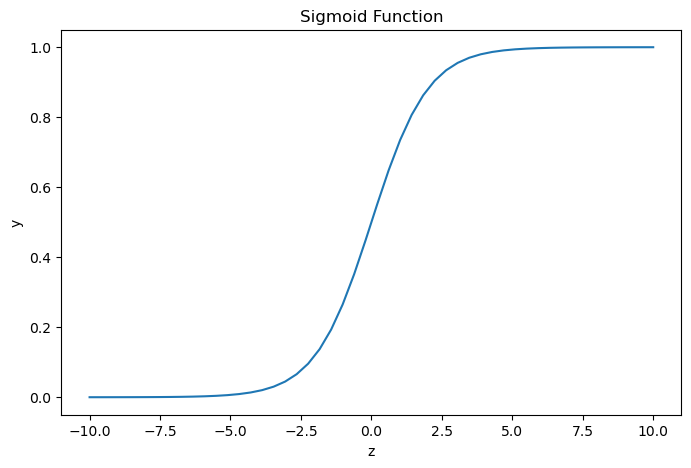

In [16]:
z = np.linspace(-10, 10, 50)   
y = 1/(1 + np.exp(-z))
plt.title("Sigmoid Function")
plt.xlabel("z") 
plt.ylabel("y")  
plt.plot(z, y) 
plt.show()

In our case, the Logistic regression model is binomial, as target variable can only have 2 possible values `0` or `1`, which represent `income <= 50K` and `income > 50k` respectively.

In [17]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
clf_logistic = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", log_model)])

In [22]:
clf_logistic.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## RANDOM FOREST CLASSIFICATION
The **Random Forest Classifier** is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object. It is an ensemble tree-based learning algorithm.

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
clf_random_forest = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_model)])

In [24]:
clf_random_forest.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## XGBOOST CLASSIFICATION
**XGBoost** is short for extreme gradient boosting. This method is based on decision trees and improves on other methods such as **random forest** and **gradient boost**. It builds decision trees sequentially with each tree attempting to correct the mistakes made by the previous one. The objective function in **XGBoost** consists of two parts: a loss function and a regularization term. The loss function measures how well the model fits the data and the regularization term simplify complex trees. 

In [25]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = "logloss", random_state=RANDOM_STATE)
clf_xgb = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb_model)])

In [26]:
clf_xgb.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## MODEL COMPARISON

**Accuracy** is one of the main metrics for evaluating classification models. **Accuracy** is the proportion of predictions our model got right. Formally, accuracy has the following definition:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Accuracy** alone doesn't tell the full story when you're working with a class-imbalanced data set, where there is a significant disparity between the number of positive and negative labels. Metrics for evaluating class-imbalanced problems are **precision** and **recall**.

In [37]:
models = {
    "Logistic Regression": clf_logistic,
    "Random Forest": clf_random_forest,
    "XGBoost": clf_xgb
}

2025/09/28 20:37:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/28 20:37:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/28 20:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


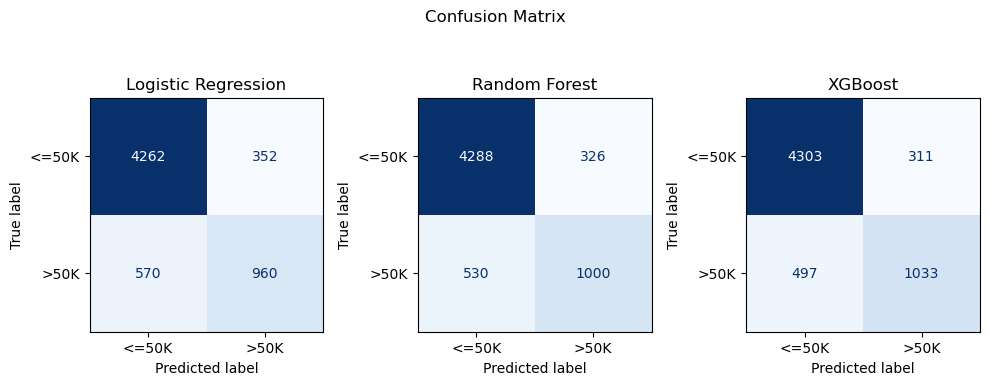

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.849935   0.731707  0.627451  0.675581
Random Forest        0.860677   0.754148  0.653595  0.700280
XGBoost              0.868490   0.768601  0.675163  0.718859


In [38]:
results = {}
fig, axes = plt.subplots(1, len(models), figsize=(10, 4))

for i, (name, model) in enumerate(models.items()):
    with mlflow.start_run(run_name=name):
        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Log model
        mlflow.sklearn.log_model(model, name= "model")

        # Confusion matrix
        cf = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=["<=50K", ">50K"])
        disp.plot(cmap=plt.cm.Blues, ax= axes[i], colorbar=False)
        axes[i].set_title(f"{name}")

fig.suptitle("Confusion Matrix")
plt.tight_layout()
plt.show()
results_df = pd.DataFrame(results).T
print(results_df)

In [39]:
best_model_name = results_df["F1 Score"].idxmax()
print("Best model:", best_model_name)

Best model: XGBoost


## MODEL COMPARISON WITH CROSS-VALIDATION (another approach)

**Cross-validation** is a technique for assessing how a classification model will perform on new, unseen data by repeatedly splitting the dataset into multiple train and test sets, training the model on the training sets, and evaluating its performance on the corresponding test set. This process helps detect overfitting (where the model learns training data too well but performs poorly on new data) and provides a more robust and reliable estimate of the model's true generalization ability compared to a single train-test split. 

We use the popular method known as **K-Fold cross-validation**, where the data is split into 'K' folds. For example, in 5-fold cross-validation, the data is split into five parts. The model is then trained and validated five times, with each fold being used as the test set once, and the remaining four folds used for training. 

In [30]:
models = {
    "Dummy-mostfreq": dummy_mostfreq_clf,
    "Dummy-stratified": dummy_strat_clf,
    "Logistic Regression": clf_logistic,
    "Random Forest": clf_random_forest,
    "XGBoost": clf_xgb
}
scoring = {'accuracy': 'accuracy',
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro',
           'roc_auc': 'roc_auc'}

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [33]:
def eval_cv(models, X, y):
    rows = []
    for name, pipe in models.items():
        res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
        row = {'model': name}
        for m in scoring:
            row[f'{m}_mean'] = np.mean(res[f'test_{m}'])
            row[f'{m}_std']  = np.std(res[f'test_{m}'])
        rows.append(row)
    return pd.DataFrame(rows).sort_values('f1_macro_mean', ascending=False)

In [34]:
cv_df = eval_cv(models, X_train, y_train)
cv_df

,model,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,f1_macro_mean,f1_macro_std,roc_auc_mean,roc_auc_std
4,XGBoost,0.864125,0.005041,0.797155,0.008390,0.810025,0.007673,0.921423,0.004121
3,Random Forest,0.853137,0.004240,0.776789,0.006868,0.792027,0.006425,0.902075,0.004119
2,Logistic Regression,0.846626,0.005887,0.765737,0.008733,0.781631,0.008662,0.902839,0.005388
1,Dummy-stratified,0.634003,0.004231,0.506441,0.005367,0.506462,0.005404,0.500278,0.003900
0,Dummy-mostfreq,0.750956,0.000020,0.500000,0.000000,0.428884,0.000007,0.500000,0.000000


In [43]:
best_model_name = cv_df.iloc[0]['model']
print("Best model:", best_model_name)

Best model: XGBoost


In [44]:
best_model = models[best_model_name]

## BEST MODEL EVALUATION


In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, classification_report

Best model: XGBoost
              precision    recall  f1-score   support

           0      0.896     0.933     0.914      4614
           1      0.769     0.675     0.719      1530

    accuracy                          0.868      6144
   macro avg      0.833     0.804     0.817      6144
weighted avg      0.865     0.868     0.866      6144



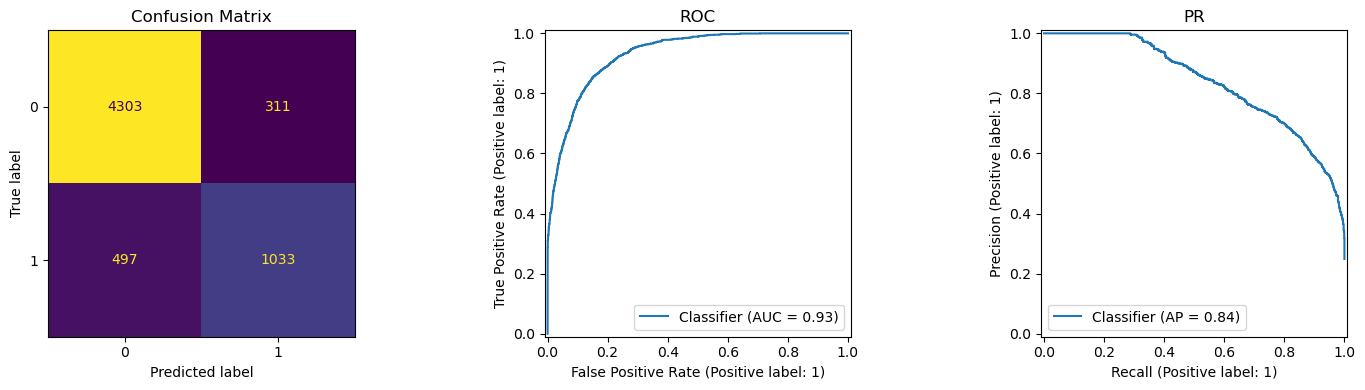

In [49]:
best_pipe = best_model.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
print(f'Best model: {best_model_name}')
print(classification_report(y_test, y_pred, digits=3))

has_proba = hasattr(best_pipe.named_steps['classifier'], 'predict_proba')
y_proba = best_pipe.predict_proba(X_test)[:,1] if has_proba else None

if has_proba:
    fig, axes = plt.subplots(1,3, figsize=(15,4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], colorbar=False)
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
    axes[0].set_title('Confusion Matrix'); axes[1].set_title('ROC'); axes[2].set_title('PR')
    plt.tight_layout(); plt.show()
else:
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False)
    plt.title('Confusion Matrix'); plt.show()

The obtained values are:
- **TN = 4303,  FP = 311, FN = 497, TP = 1033**
- **Accuracy:** ≈ 0.868  
- **Precision (positive):** TP/(TP+FP) = 1,033/1,344 ≈ **0.77**  
- **Recall (positive):** TP/(TP+FN) = 1,033/1,530 ≈ **0.68**  
- **Specificity:** TN/(TN+FP) = 4,303/4,614 ≈ **0.93**  
- **F1 (positive):** ≈ **0.72**  
With the default 0.5 threshold, the model keeps **false positives low** (high specificity), while recovering a **good share of positives** (recall ~0.68). If the business prefers catching more `>50K` cases, we can **lower the threshold** to trade precision for higher recall. 
- **ROC–AUC ≈ 0.93:** excellent probability ranking across all thresholds (well above random 0.5).  
- **PR–AUC ≈ 0.84:** strong performance on the **positive class** under class imbalance; precision remains high even as recall increases.


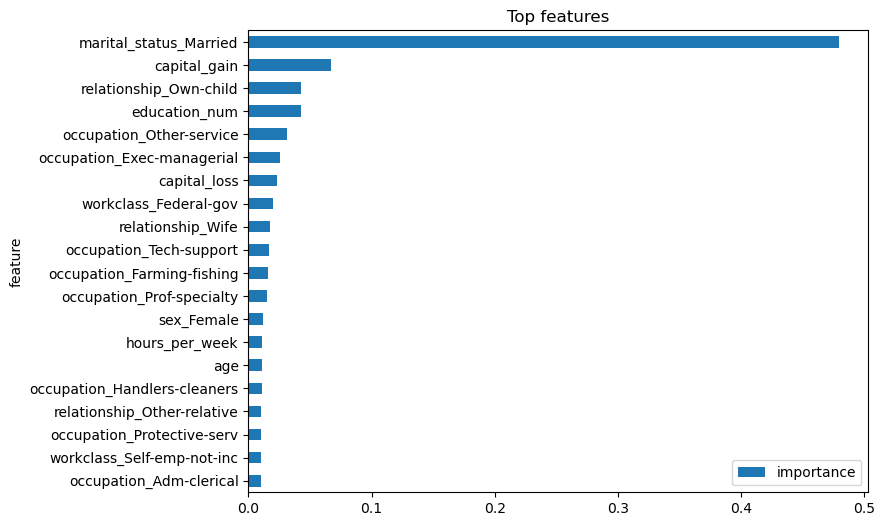

In [50]:
clf = best_pipe.named_steps['classifier']
prep = best_pipe.named_steps['preprocessor']

if hasattr(clf, 'feature_importances_'):
    ohe = prep.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = ohe.get_feature_names_out(input_features=cat_cols)
    num_feature_names = num_cols
    feature_names = np.concatenate([cat_feature_names, num_feature_names])
    importances = clf.feature_importances_
    idx = np.argsort(importances)[-20:][::-1]
    top_features = pd.DataFrame({'feature': feature_names[idx], 'importance': importances[idx]})
    top_features.plot(x='feature', y='importance', kind='barh', figsize=(8,6)); plt.gca().invert_yaxis(); plt.title('Top features'); plt.show()
elif hasattr(clf, 'coef_'):
    ohe = prep.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = ohe.get_feature_names_out(input_features=cat_cols)
    num_feature_names = num_cols
    feature_names = np.concatenate([cat_feature_names, num_feature_names])
    coef = np.abs(clf.coef_).ravel()
    idx = np.argsort(coef)[-20:][::-1]
    top_coef = pd.DataFrame({'feature': feature_names[idx], 'coef_abs': coef[idx]})
    top_coef.plot(x='feature', y='coef_abs', kind='barh', figsize=(8,6)); plt.gca().invert_yaxis(); plt.title('Top coefficients |LR|'); plt.show()
else:
    print('Feature importance not available for this classifier.')

**Feature importance (top features)**  
- `marital_status_Married` dominates the splits → married status is the **strongest indicator** of income `>50K` in this dataset.  
- `capital_gain` and `education_num` follow, aligning with economic intuition (investment gains and years of education correlate with higher income).  
- Occupation-related dummies (e.g., `Exec-managerial`, `Tech-support`) also contribute, along with `hours_per_week` and `age`.


**Why XGBoost wins**  
- Captures **non-linearities** and **interactions** between demographic and economic attributes.  
- Handles mixed categorical/continuous inputs via one-hot features without scaling.  
- More stable macro-F1/ROC–AUC across folds than the baselines and linear models.

**Next steps**  
- **Threshold tuning** (maximize F1 or set a custom precision/recall target).  
- Small **hyperparameter search** (learning rate, max_depth, n_estimators, min_child_weight, subsampling).  
- Optional **calibration** (Platt/Isotonic) if calibrated probabilities are required.

## SAVING THE MODELS

In [54]:
import os 
MODELS_DIR = Path("../models")
os.makedirs(MODELS_DIR, exist_ok=True)

In [55]:
joblib.dump(clf_logistic, os.path.join(MODELS_DIR, "logistic_regression.joblib"))
joblib.dump(clf_random_forest, os.path.join(MODELS_DIR, "random_forest.joblib"))
joblib.dump(clf_xgb, os.path.join(MODELS_DIR, "xgboost.joblib"))
joblib.dump(best_pipe, os.path.join(MODELS_DIR, "best_model.joblib"));